an attempt at interactive exploration of inheritance structures, with an emphasis on understanding where and why methods get over-ridden. 


In [1]:
import yt
from yt.utilities.io_handler import BaseIOHandler, BaseParticleIOHandler
import collections
import inspect
from graphviz import Digraph
from typing import Optional, Any

### testing a Digraph object

In [2]:
# Add nodes 1 and 2
dot = Digraph()
dot.node('1',label='what')
dot.node('2')
dot.node('3')

# Add edge between 1 and 2
dot.edge('2','1')
dot.edge('3','1')

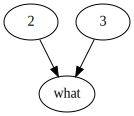

In [3]:
dot

Recursively construct inheritance structure, highlighting when a class defines or overrides a specified function

In [4]:
class ChildNode:
    
    def __init__(self, 
                 child: Any, 
                 child_id: int, 
                 parent: Optional[Any]=None, 
                 parent_id: Optional[int]=None,
                 color: Optional[str]="#000000"):
        self.child = child
        self.child_name = child.__name__
        self._child_id = child_id
        self.parent = parent
        
        self._parent_id = parent_id
        self.parent_name = None
        if parent:
            self.parent_name = parent.__name__
            
        self.color = color
    
    @property
    def child_id(self) -> str:
        return str(self._child_id)
    
    @property
    def parent_id(self) -> str:        
        if self._parent_id:            
            return str(self._parent_id)
        return
    
        
class ClassGraphTree:
    
    def __init__(self, 
                 baseclass: Any, 
                 funcname: Optional[str]=None, 
                 default_color: Optional[str]= "#000000",
                 func_override_color: Optional[str]= "#ff0000",
                 **kwargs):
        """
        baseclass: 
            the starting base class to begin mapping from
        funcname: 
            the name of a function to watch for overrides
        default_color: t
            he default outline color of nodes, in any graphviz string
        func_override_color: 
            the outline color of nodes that override funcname, in any graphviz string
        **kwargs:
            any additional keyword arguments are passed to graphviz.Digraph(**kwargs)
        """
        self.baseclass = baseclass
        self.basename: str = baseclass.__name__
        self.funcname = funcname
        self.dot = Digraph(**kwargs)
        self._nodenum: int = 0
        self._node_list = []        
        self._current_node = 1                
        self._default_color = default_color
        self._override_color = func_override_color
        self.build()
        
    def _get_source_info(self, obj) -> Optional[str]:
        f = getattr(obj, self.funcname)
        if isinstance(f, collections.abc.Callable):
            return f"{inspect.getsourcefile(f)}:{inspect.getsourcelines(f)[1]}"
        return None
    
    def _node_overrides_func(self, child, parent) -> bool:
        childsrc = self._get_source_info(child)
        parentsrc = self._get_source_info(parent)
        if childsrc != parentsrc:            
            return True # it overrides! 
        return False        

    def _get_new_node_color(self, child, parent) -> str:
        if self.funcname and self._node_overrides_func(child, parent):
            return self._override_color
        return self._default_color

    def _get_baseclass_color(self) -> str:
        color = self._default_color        
        if self.funcname:
            f = getattr(self.baseclass, self.funcname)
            class_where_its_defined = f.__qualname__.split('.')[0]
            if self.basename == class_where_its_defined: 
                # then its defined here, use the override color
                color = self._override_color
        return color
        
    
    def check_subclasses(self, parent, parent_id: int, node_i: int) -> int:
        for child in parent.__subclasses__():            
            color = self._get_new_node_color(child, parent)
            new_node = ChildNode(child, node_i, parent=parent, parent_id=parent_id, color=color)            
            self._node_list.append(new_node)
            
                
            node_i += 1
            node_i = self.check_subclasses(child, node_i - 1, node_i)
        return node_i
            
            
    def build(self):
        
        # first construct all the nodes        
        
        color = self._get_baseclass_color()        
        self._node_list.append(ChildNode(self.baseclass, self._current_node, parent=None, color=color))
        self._current_node += 1
        
        _ = self.check_subclasses(self.baseclass, self._current_node - 1, self._current_node)        
            
        # now build the graph
        for node in self._node_list:            
            self.dot.node(node.child_id, label=node.child_name, color=node.color)
            if node.parent:                
                self.dot.edge(node.child_id, node.parent_id)                   
            


In [5]:
save_dir = "../"

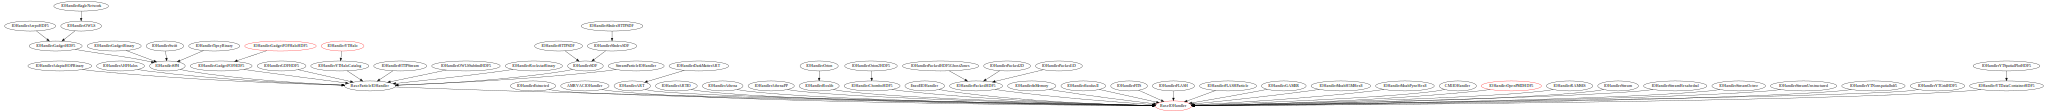

In [6]:
c = ClassGraphTree(BaseIOHandler, "_read_particle_selection")
c.dot.render(filename=f"{save_dir}BaseIOHandler_read_particle_selection", format="pdf")
c.dot


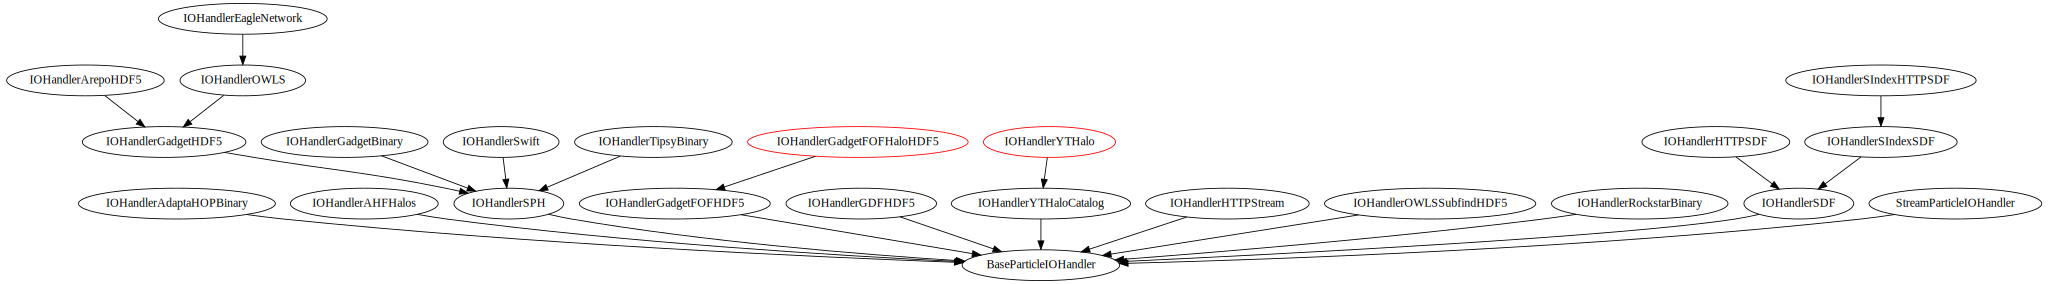

In [7]:
c = ClassGraphTree(BaseParticleIOHandler, "_read_particle_selection")
c.dot.render(filename=f"{save_dir}BaseParticleIOHandler_read_particle_selection", format="pdf")
c.dot

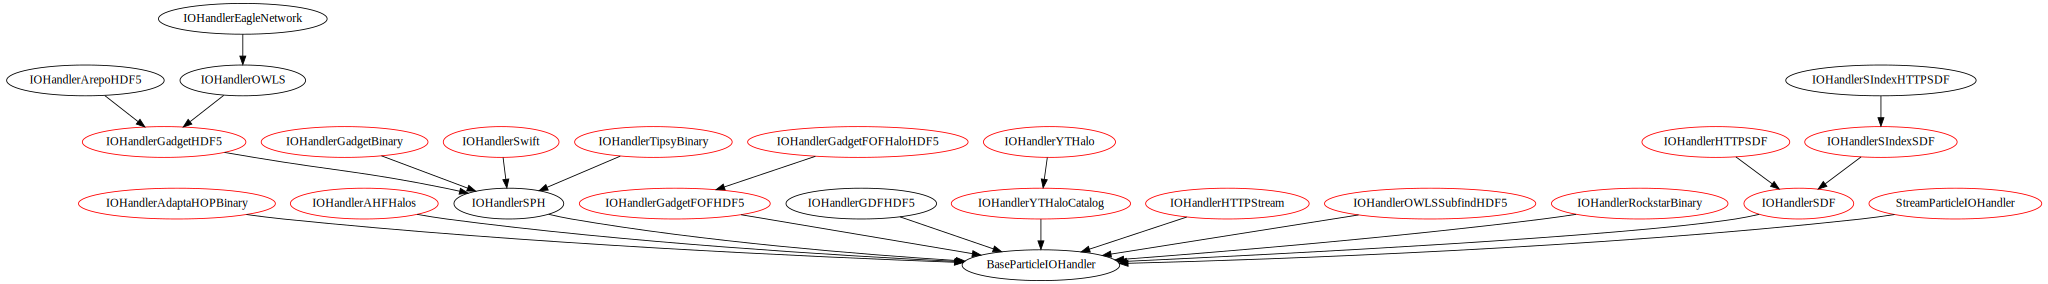

In [8]:
c = ClassGraphTree(BaseParticleIOHandler, "_read_particle_coords")
c.dot.render(filename=f"{save_dir}BaseParticleIOHandler_read_particle_coords", format="pdf")
c.dot

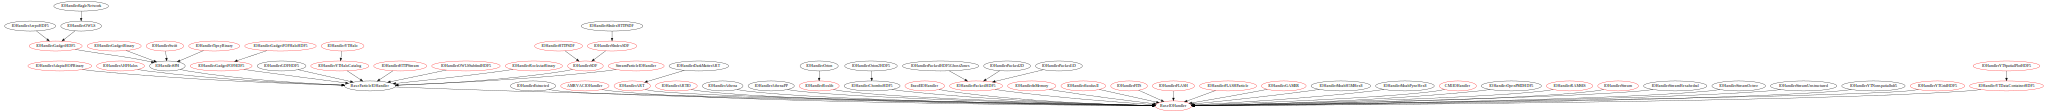

In [9]:
c = ClassGraphTree(BaseIOHandler, "_read_particle_coords")
c.dot.render(filename=f"{save_dir}BaseIOHandler_read_particle_coords", format="pdf")
c.dot

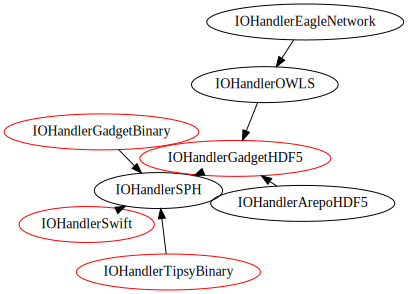

In [10]:
from yt.frontends.sph.io import IOHandlerSPH
c = ClassGraphTree(IOHandlerSPH, "_read_particle_coords", engine="neato")
c.dot.render(filename=f"{save_dir}IOHandlerSPH_read_particle_coords", format="pdf")
c.dot